# Forecasting Crime for 2025 with San Francisco's Police Incident Report Data

## Importing Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor

from statsmodels.graphics.tsaplots import plot_pacf
import holidays

## Load and Transform Data

In [2]:
data = pd.read_csv('unified_dataset.csv', index_col=0)
data.head()

,Incident Year,Incident Day of Week,Row ID,Incident ID,Incident Number,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,...,Supervisor District,Supervisor District 2012,Latitude,Longitude,Neighborhoods,Current Supervisor Districts,Current Police Districts,time,month,month_cont
9,2023,Thursday,125482604134,1254826,230187101,4134,Assault,Simple Assault,Battery,Open or Active,...,10.0,10.0,37.762290,-122.401324,54.0,9.0,2.0,17.50,3,3.52
191,2021,Wednesday,104785804134,1047858,210426383,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,9.0,9.0,37.753837,-122.418594,53.0,2.0,3.0,8.30,7,7.23
204,2021,Friday,103693404134,1036934,210345909,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,5.0,6.0,37.785893,-122.419739,20.0,10.0,4.0,9.67,6,6.13
262,2021,Monday,104980919057,1049809,210440703,19057,Disorderly Conduct,Intimidation,Terrorist Threats,Open or Active,...,5.0,6.0,37.783214,-122.410765,20.0,10.0,5.0,12.33,7,7.39
267,2019,Tuesday,103770002004,1037700,210348157,2004,Sex Offense,Rape,"Rape, Forcible, W/ Force",Open or Active,...,6.0,6.0,37.775953,-122.408846,32.0,10.0,1.0,16.50,6,6.37


In [3]:
# restore datetime from original dataset
original_data = pd.read_csv('Police_Department_Incident_Reports__2018_to_Present_20250303.csv')
data['datetime'] = original_data.iloc[data.index]['Incident Datetime']
del original_data

data.head()

,Incident Year,Incident Day of Week,Row ID,Incident ID,Incident Number,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,...,Supervisor District 2012,Latitude,Longitude,Neighborhoods,Current Supervisor Districts,Current Police Districts,time,month,month_cont,datetime
9,2023,Thursday,125482604134,1254826,230187101,4134,Assault,Simple Assault,Battery,Open or Active,...,10.0,37.762290,-122.401324,54.0,9.0,2.0,17.50,3,3.52,2023/03/16 05:30:00 PM
191,2021,Wednesday,104785804134,1047858,210426383,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,9.0,37.753837,-122.418594,53.0,2.0,3.0,8.30,7,7.23,2021/07/07 08:18:00 AM
204,2021,Friday,103693404134,1036934,210345909,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,6.0,37.785893,-122.419739,20.0,10.0,4.0,9.67,6,6.13,2021/06/04 09:40:00 AM
262,2021,Monday,104980919057,1049809,210440703,19057,Disorderly Conduct,Intimidation,Terrorist Threats,Open or Active,...,6.0,37.783214,-122.410765,20.0,10.0,5.0,12.33,7,7.39,2021/07/12 12:20:00 PM
267,2019,Tuesday,103770002004,1037700,210348157,2004,Sex Offense,Rape,"Rape, Forcible, W/ Force",Open or Active,...,6.0,37.775953,-122.408846,32.0,10.0,1.0,16.50,6,6.37,2019/06/11 04:30:00 PM


In [4]:
data['datetime'] = pd.to_datetime(data['datetime'], format="%Y/%m/%d %I:%M:%S %p").dt.round('d')
data.head()

,Incident Year,Incident Day of Week,Row ID,Incident ID,Incident Number,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,...,Supervisor District 2012,Latitude,Longitude,Neighborhoods,Current Supervisor Districts,Current Police Districts,time,month,month_cont,datetime
9,2023,Thursday,125482604134,1254826,230187101,4134,Assault,Simple Assault,Battery,Open or Active,...,10.0,37.762290,-122.401324,54.0,9.0,2.0,17.50,3,3.52,2023-03-17
191,2021,Wednesday,104785804134,1047858,210426383,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,9.0,37.753837,-122.418594,53.0,2.0,3.0,8.30,7,7.23,2021-07-07
204,2021,Friday,103693404134,1036934,210345909,4134,Assault,Simple Assault,Battery,Cite or Arrest Adult,...,6.0,37.785893,-122.419739,20.0,10.0,4.0,9.67,6,6.13,2021-06-04
262,2021,Monday,104980919057,1049809,210440703,19057,Disorderly Conduct,Intimidation,Terrorist Threats,Open or Active,...,6.0,37.783214,-122.410765,20.0,10.0,5.0,12.33,7,7.39,2021-07-13
267,2019,Tuesday,103770002004,1037700,210348157,2004,Sex Offense,Rape,"Rape, Forcible, W/ Force",Open or Active,...,6.0,37.775953,-122.408846,32.0,10.0,1.0,16.50,6,6.37,2019-06-12


Time Series Size: 2618


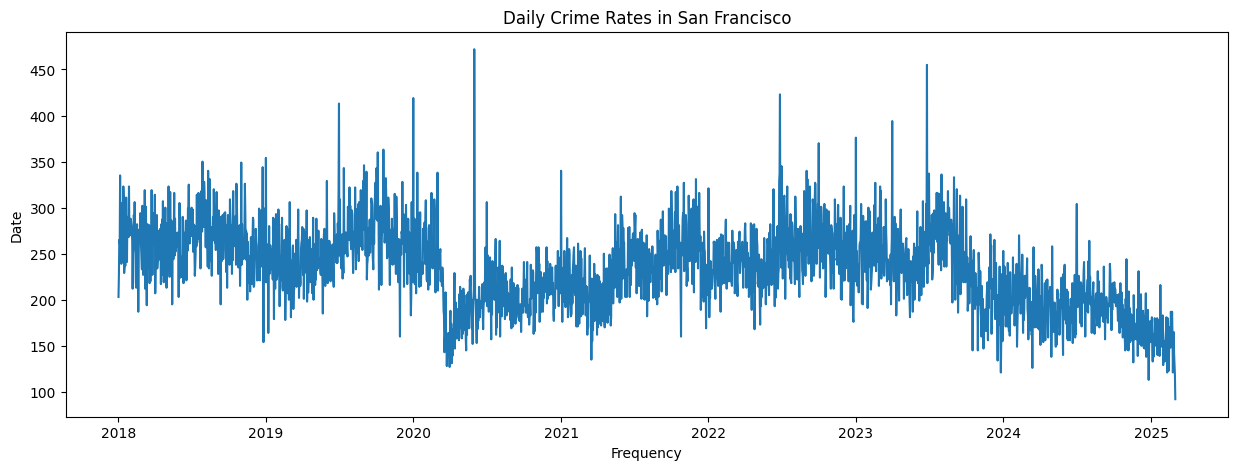

In [5]:
ts = data['datetime'].value_counts().sort_index(ascending=True)
ts = pd.DataFrame(ts)[:-1] # ignore outlier at last day of data collection (incomplete day)

print(f'Time Series Size: {len(ts)}')

fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(ts) 
ax.set_title('Daily Crime Rates in San Francisco')
ax.set_xlabel('Frequency')
ax.set_ylabel('Date')

plt.show()

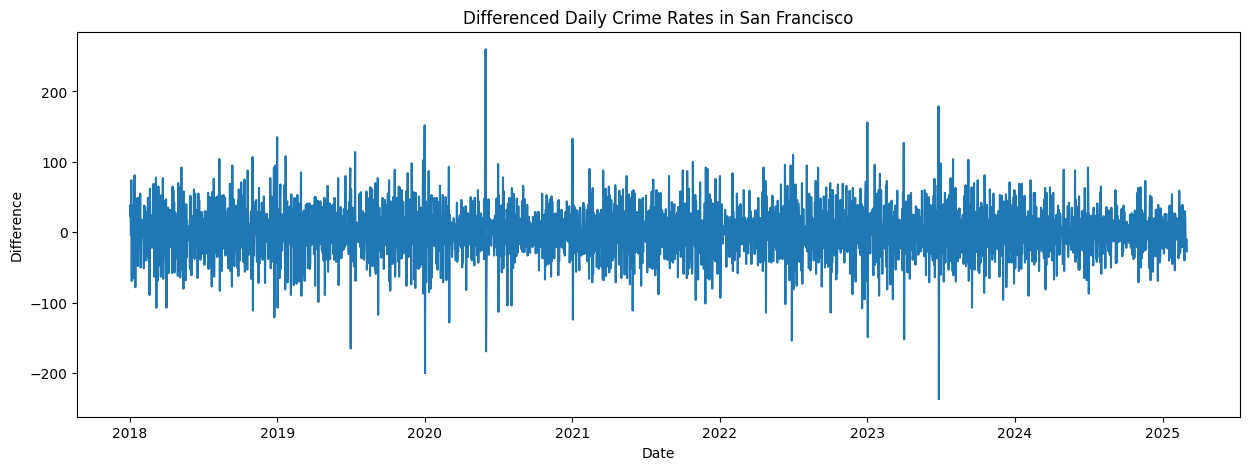

In [6]:
ts['diff1'] = ts['count'].diff(1)
ts['diff1lag1'] = ts['diff1'].shift(1)

fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(ts['diff1'])
ax.set_title('Differenced Daily Crime Rates in San Francisco')
ax.set_ylabel('Difference')
ax.set_xlabel('Date')

plt.show()

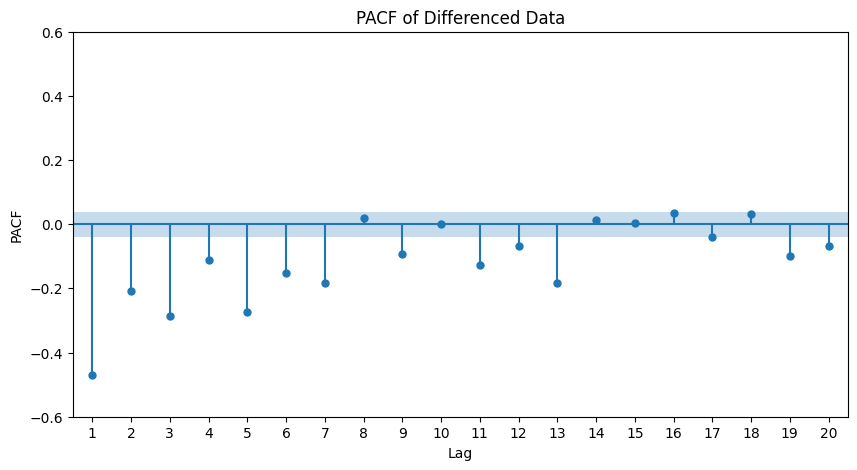

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
plot_pacf(ts['diff1'].dropna(), lags=20, ax=ax)
ax.set_title('PACF of Differenced Data')
ax.set_xticks(range(0,21))
ax.set_xlim(0.5, 20.5)
ax.set_ylim(-0.6, 0.6)
ax.set_ylabel('PACF')
ax.set_xlabel('Lag')

plt.show()

In [8]:
# create lag1, lag3, lag5 features
for lag in [1, 3, 5]:
    ts[f'lag{lag}'] = ts['count'].shift(lag)

# create rolling means and stds
ma = pd.DataFrame()
mstd = pd.DataFrame()
mtrend = pd.DataFrame()
for window in [3,7,15,30]:
    rolling = ts['count'].shift(1).rolling(window) # exclude current information
    ma[f'ma{window}'] = rolling.mean()
    mstd[f'mstd{window}'] = rolling.std()
    mtrend[f'mtrend{window}'] = ma[f'ma{window}'].diff()

ts = pd.concat([ts, ma, mstd, mtrend], axis=1)
ts

,count,diff1,diff1lag1,lag1,lag3,lag5,ma3,ma7,ma15,ma30,mstd3,mstd7,mstd15,mstd30,mtrend3,mtrend7,mtrend15,mtrend30
datetime,,,,,,,,,,,,,,,,,,
2018-01-01,203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,226,23.0,NaN,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,265,39.0,23.0,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,261,-4.0,39.0,265.0,203.0,NaN,231.333333,NaN,NaN,NaN,31.342197,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,335,74.0,-4.0,261.0,226.0,NaN,250.666667,NaN,NaN,NaN,21.455380,NaN,NaN,NaN,19.333333,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-26,165,14.0,30.0,151.0,161.0,171.0,144.333333,164.714286,161.733333,156.666667,20.816660,23.278848,20.554689,19.417968,-12.000000,0.428571,2.000000,-0.366667
2025-02-27,141,-24.0,14.0,165.0,121.0,187.0,145.666667,161.571429,160.733333,157.200000,22.479620,21.157009,19.958767,19.419862,1.333333,-3.142857,-1.000000,0.533333
2025-02-28,129,-12.0,-24.0,141.0,151.0,161.0,152.333333,156.714286,158.333333,156.700000,12.055428,21.460928,20.027362,19.643635,6.666667,-4.857143,-2.400000,-0.500000


In [9]:
# date features
ts['year'] = ts.index.year
ts['day'] = ts.index.day
ts['month'] = ts.index.month
ts['weekend'] = ts.index.weekday >= 5
ts['holiday'] = ts.index.isin(holidays.US())
ts

,count,diff1,diff1lag1,lag1,lag3,lag5,ma3,ma7,ma15,ma30,...,mstd30,mtrend3,mtrend7,mtrend15,mtrend30,year,day,month,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,1,1,False,False
2018-01-02,226,23.0,NaN,203.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,2,1,False,False
2018-01-03,265,39.0,23.0,226.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,3,1,False,False
2018-01-04,261,-4.0,39.0,265.0,203.0,NaN,231.333333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,4,1,False,False
2018-01-05,335,74.0,-4.0,261.0,226.0,NaN,250.666667,NaN,NaN,NaN,...,NaN,19.333333,NaN,NaN,NaN,2018,5,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-26,165,14.0,30.0,151.0,161.0,171.0,144.333333,164.714286,161.733333,156.666667,...,19.417968,-12.000000,0.428571,2.000000,-0.366667,2025,26,2,False,False
2025-02-27,141,-24.0,14.0,165.0,121.0,187.0,145.666667,161.571429,160.733333,157.200000,...,19.419862,1.333333,-3.142857,-1.000000,0.533333,2025,27,2,False,False
2025-02-28,129,-12.0,-24.0,141.0,151.0,161.0,152.333333,156.714286,158.333333,156.700000,...,19.643635,6.666667,-4.857143,-2.400000,-0.500000,2025,28,2,False,False


## Forecasting with XGBoost

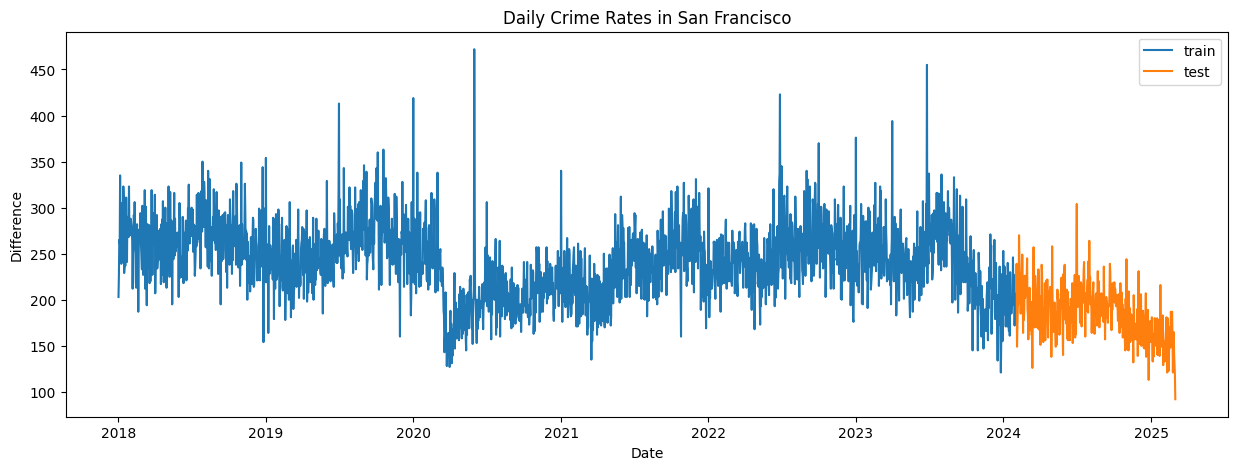

In [10]:
# simple train test split
cutoff_date = "2024-02-01"
train = ts[ts.index <= cutoff_date]
test = ts[ts.index > cutoff_date]

fig, ax = plt.subplots(1,1, figsize=(15, 5))
ax.plot(train['count'], label='train')
ax.plot(test['count'], label='test')
ax.set_title('Daily Crime Rates in San Francisco')
ax.set_ylabel('Difference')
ax.set_xlabel('Date')
ax.legend()

plt.show()

In [11]:
trainX = train.drop(labels=['count','diff1'], axis=1)
trainY = train['count']
testX = test.drop(labels=['count','diff1'], axis=1)
testY = test['count']

xgb = XGBRegressor(n_estimators=500)
xgb.fit(trainX, trainY, eval_set=[(testX, testY)], verbose=50)

[0]	validation_0-rmse:53.67575
[50]	validation_0-rmse:36.94927
[100]	validation_0-rmse:36.79486
[150]	validation_0-rmse:36.66023
[200]	validation_0-rmse:36.69640
[250]	validation_0-rmse:36.68403
[300]	validation_0-rmse:36.67085
[350]	validation_0-rmse:36.66459
[400]	validation_0-rmse:36.66476
[450]	validation_0-rmse:36.66380
[499]	validation_0-rmse:36.66347


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# predict one date ahead function
def predict_next_day(data, model):
    # add row to dataframe
    nextdate = data.index[-1] + pd.Timedelta(days=1)
    data.loc[nextdate] = None

    data.loc[nextdate, 'diff1lag1'] = data.iloc[-2]['diff1']
    data.loc[nextdate, 'lag1'] = data.iloc[-2]['count']
    data.loc[nextdate, 'lag3'] = data.iloc[-4]['count']
    data.loc[nextdate, 'lag5'] = data.iloc[-7]['count']

    data.loc[nextdate, 'year'] = nextdate.year
    data.loc[nextdate, 'day'] = nextdate.day
    data.loc[nextdate, 'month'] = nextdate.month
    data.loc[nextdate, 'weekend'] = nextdate.weekday() >= 5
    data.loc[nextdate, 'holiday'] = nextdate in holidays.US()

    for window in [3,7,15,30]:
        rolling = data['count'].shift(1).rolling(window) # exclude current information
        data.loc[nextdate, f'ma{window}'] = rolling.mean().iloc[-1]
        data.loc[nextdate, f'mstd{window}'] = rolling.std().iloc[-1]
        data.loc[nextdate, f'mtrend{window}'] = data[f'ma{window}'].diff().iloc[-1]
    
    # predict day
    X = data.drop(labels=['count', 'diff1'], axis=1).iloc[-1]
    pred = model.predict(X)
    print(pred)
    
predict_next_day(train, xgb)
   


/var/folders/rl/kfwnr9bn039czmp7dm8_ycmm0000gn/T/ipykernel_49690/3939764580.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[nextdate] = None


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:2024-02-02 00:00:00: object